In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time
from itertools import combinations
import math

In [2]:
def parse_benchmark(filename):
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]  # Read non-empty lines
    
    # Read universe size (m) and number of subsets (n)
    universe_size, num_subsets = map(int, lines[0].split())
    universe = set(range(1, universe_size + 1))
    
    # Initialize empty subsets (indices 0 to num_subsets-1)
    subsets = [set() for _ in range(num_subsets)]
    
    current_element = 1  # Elements start at 1
    line_index = 1       # Start reading from line 1 (after m, n)
    count=0
    while line_index < len(lines) and current_element <= universe_size:
        # Read the number of subsets containing current_element
        num_subsets_containing = int(lines[line_index])
        count+=num_subsets_containing
        line_index += 1
        
        # Read all subset indices (may span multiple lines)
        subset_indices = []
        subset_indices_read = 0
        
        while (line_index < len(lines) and (subset_indices_read < num_subsets_containing)) : 
            # Split the line into integers
            parts = list(map(int, lines[line_index].split()))
            
            # Add them to subset_indices
            subset_indices.extend(parts)
            subset_indices_read += len(parts)
            
            # Move to next line
            line_index += 1
        
        # Assign current_element to each subset in subset_indices
        for subset_idx in subset_indices:
            if 1 <= subset_idx <= num_subsets:
                subsets[subset_idx - 1].add(current_element)
        
        current_element += 1  # Move to next element
    
    return universe, subsets,count/len(universe)

# Example usage
universe, subsets,k_avg = parse_benchmark("Problem_set_4/scp41.txt")
print(f"Universe size: {len(universe)}")
print(f"Number of subsets: {len(subsets)}")
print("\nFirst 5 subsets:")
for i, subset in enumerate(subsets[:5], 1):
    print(f"Subset {i}: {subset}") 

Universe size: 200
Number of subsets: 1000

First 5 subsets:
Subset 1: {32, 196, 199, 107, 75, 76, 18, 190}
Subset 2: {160, 3, 4, 138, 108, 110, 181}
Subset 3: {128, 98, 10, 12, 110, 154}
Subset 4: {118, 76, 102, 175}
Subset 5: {160, 106, 180, 86}


Max Covering Probelm Class 

In [69]:
class MaximumCoveringProblem:
    def __init__(self, U, S, k):
        """
        Initialize the Maximum Covering Problem
        :param U: Universe of elements (list)
        :param S: Collection of subsets (list of lists)
        :param k: Number of subsets to select (int)
        """
        self.U = U
        self.S = S
        self.k = k
        self.n = len(U)  # Number of elements in universe
        self.m = len(S)   # Number of subsets
        
        # Create a mapping from element to subsets that contain it
        self.element_to_subsets = defaultdict(list)
        for i, subset in enumerate(S):
            for elem in subset:
                self.element_to_subsets[elem].append(i)
        
        # For DFS comparison
        self.best_dfs_solution = None
        self.best_dfs_coverage = 0
    
    def evaluate(self, solution):
        """
        Evaluate a solution (binary vector) by counting the number of unique elements covered
        :param solution: Binary vector representing selected subsets
        :return: Number of covered elements
        """
        selected_subsets = [self.S[i] for i in range(self.m) if solution[i] == 1]
        covered = set()
        for subset in selected_subsets:
            covered.update(subset)
        return len(covered)
    
    def is_valid(self, solution):
        """Check if solution has exactly k subsets selected"""
        return sum(solution) == self.k
    
    def generate_random_solution(self):
        """Generate a random valid solution (exactly k subsets selected)"""
        solution = [0] * self.m
        indices = random.sample(range(self.m), self.k)
        for idx in indices:
            solution[idx] = 1
        return solution
    
    def solve_with_DFS(self, max_time=60):
        """Exact solution using Depth-First Search (for comparison)"""
        self.best_dfs_solution = None
        self.best_dfs_coverage = 0
        start_time = time()
        nmbr=0
        # We'll use combinations to generate all possible k-subset selections
        for combo in combinations(range(self.m), self.k):
            if time() - start_time > max_time:
                break  # Timeout
            coverage = len(set().union(*[self.S[i] for i in combo]))
            if coverage > self.best_dfs_coverage:
                self.best_dfs_coverage = coverage
                self.best_dfs_solution = combo
                print(f"New best DFS solution found with coverage: {coverage}")
                nmbr+=1
        print(f"Number of DFS solutions evaluated: {nmbr}")
        # Convert to binary solution format
        if self.best_dfs_solution:
            solution = [0] * self.m
            for idx in self.best_dfs_solution:
                solution[idx] = 1
            return solution, self.best_dfs_coverage
        return None, 0


DiscretePSO

In [68]:
class DiscretePSO:
    def __init__(self, problem, num_particles=50, max_iter=100, w=0.8, c1=2.05, c2=2.05):
        """
        Initialize the Discrete PSO solver
        :param problem: MaximumCoveringProblem instance
        :param num_particles: Number of particles in the swarm
        :param max_iter: Maximum number of iterations
        :param w: Inertia weight
        :param c1: Cognitive coefficient
        :param c2: Social coefficient
        """
        self.problem = problem
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        # Initialize particles
        self.particles = []
        for _ in range(num_particles):
            # Random continuous position in [0,1]^m
            position = np.random.rand(problem.m)
            # Convert to valid binary solution
            binary_solution = self._discretize(position)
            # Random velocity
            velocity = np.random.randn(problem.m) * 0.1
            
            fitness = problem.evaluate(binary_solution)
            
            # Personal best
            pbest = {
                'position': position.copy(),
                'binary_solution': binary_solution.copy(),
                'fitness': fitness
            }
            
            self.particles.append({
                'position': position,
                'velocity': velocity,
                'binary_solution': binary_solution,
                'fitness': fitness,
                'pbest': pbest
            })
        
        # Global best
        self.gbest = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest'].copy()
    
    def _discretize(self, continuous_position):
        """Convert continuous position to binary solution with exactly k 1's"""
        # Get indices of top k values
        top_k_indices = np.argpartition(continuous_position, -self.problem.k)[-self.problem.k:]
        binary_solution = [0] * self.problem.m
        for idx in top_k_indices:
            binary_solution[idx] = 1
        return binary_solution
    
    def optimize(self):
        """Run the PSO optimization"""
        convergence_curve = []
        best_fitness_history = []
        diversity_history = []  # New: Store diversity per iteration
        for iteration in range(self.max_iter):
            # Temporary storage for binary solutions (needed for diversity calculation)
            current_binary_solutions = []
            for particle in self.particles:
                # Update velocity
                r1, r2 = np.random.rand(2)
                cognitive = self.c1 * r1 * (particle['pbest']['position'] - particle['position'])
                social = self.c2 * r2 * (self.gbest['position'] - particle['position'])
                particle['velocity'] = self.w * particle['velocity'] + cognitive + social
                
                # Update position
                particle['position'] = particle['position'] + particle['velocity']
                # Clip to [0,1] range
                particle['position'] = np.clip(particle['position'], 0, 1)
                
                # Discretize to binary solution
                particle['binary_solution'] = self._discretize(particle['position'])
                current_binary_solutions.append(particle['binary_solution'])
                particle['fitness'] = self.problem.evaluate(particle['binary_solution'])
                
                # Update personal best
                if particle['fitness'] > particle['pbest']['fitness']:
                    particle['pbest']['position'] = particle['position'].copy()
                    particle['pbest']['binary_solution'] = particle['binary_solution'].copy()
                    particle['pbest']['fitness'] = particle['fitness']
             # --- New: Calculate diversity for this iteration ---
            diversity = calculate_diversity(current_binary_solutions)
            diversity_history.append(diversity)
            # Update global best
            current_best = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest']
            if current_best['fitness'] > self.gbest['fitness']:
                self.gbest = current_best.copy()
            
            convergence_curve.append(self.gbest['fitness'])
            best_fitness_history.append(self.gbest['fitness'])
            
            # Early stopping if optimal solution found
            if self.gbest['fitness'] == self.problem.n:
                break
        
        return self.gbest, convergence_curve,diversity_history


In [6]:
def calculate_diversity(binary_solutions):
    """Compute average Hamming distance between all particle pairs"""
    total_distance = 0
    n_particles = len(binary_solutions)
    n_pairs = n_particles * (n_particles - 1) // 2
    
    for i in range(n_particles):
        for j in range(i+1, n_particles):
            # Hamming distance = number of differing bits
            distance = np.sum(binary_solutions[i] != binary_solutions[j])
            total_distance += distance
    
    avg_distance = total_distance / n_pairs
    normalized_diversity = avg_distance / len(binary_solutions[0]) if binary_solutions else 0
    return normalized_diversity



In [7]:
def parameter_tuning_experiment(universetest , subsettest , num ,k):
    """Experiment to tune PSO parameters"""
    # Fixed problem instance

    
   
    problem = MaximumCoveringProblem(universetest, subsettest, k)
    print(f"Problem instance loaded: {len(universetest)} elements, {len(subsettest)} subsets")
    print(f"Selecting k = {k} subsets")
    # Parameter combinations to try
    param_combinations = [
        {'w': 0.4, 'c1': 1.0, 'c2': 1.0},
        {'w': 0.4, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.4, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.4, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.95, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.95, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.95, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.95, 'c1': 1.0, 'c2': 1.0},
        {'w': 0.8, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.8, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.8, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.8, 'c1': 1.0, 'c2': 1.0},
    ]
    
    results = []
    for params in param_combinations:
        pso = DiscretePSO(problem, num_particles=30, max_iter=100, 
                         w=params['w'], c1=params['c1'], c2=params['c2'])
        start_time = time()
        best_solution, convergence = pso.optimize()
        runtime = time() - start_time
        #print(f"best solution {best_solution}")
        results.append({
            'params': params,
            'best_fitness': best_solution['fitness'],
            'runtime': runtime,
            'convergence': convergence
        })
    
    # Plot convergence curves
    plt.figure(figsize=(10, 6))
    for res in results:
        label = f"w={res['params']['w']}, c1={res['params']['c1']}, c2={res['params']['c2']}"
        plt.plot(res['convergence'], label=label)
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.title(f'PSO Parameter Tuning - Convergence Curves {num}')
    plt.legend()
    plt.grid()
    plt.show()
    
    return results

In [7]:
def parameter_tuning_experiment2(universetest, subsettest, num, k, n_executions=5):
    """Enhanced parameter tuning experiment with complete fitness tracking"""
    problem = MaximumCoveringProblem(universetest, subsettest, k)
    print(f"Problem instance loaded: {len(universetest)} elements, {len(subsettest)} subsets")
    print(f"Selecting k = {k} subsets\n")
    
    # Define parameter ranges to test
    iterations = [100, 150]
    particles = [50, 80,100]
    c_values = [1.5, 2.05]
    w_values = [0.8, 0.9]
    
    # Prepare comprehensive results storage
    results = []
    test_number = 1
    
    # Print header
    print(f"{'#test':<6}{'#iter':<8}{'#parts':<8}{'c1':<5}{'c2':<5}{'w':<6}{'F(x)':<6}  Execution Results")
    print("-"*80)
    
    # Test all parameter combinations
    for max_iter in iterations:
        for num_particles in particles:
            for c1 in c_values:
                for c2 in c_values:
                    for w in w_values:
                        execution_results = []
                        max_fitness = -1  # Track maximum fitness
                        
                        # Run multiple executions
                        for execution in range(n_executions):
                            pso = DiscretePSO(problem, 
                                            num_particles=num_particles,
                                            max_iter=max_iter,
                                            w=w,
                                            c1=c1,
                                            c2=c2)
                            
                            best_solution, _ = pso.optimize()
                            fitness = best_solution['fitness']
                            execution_results.append(fitness)
                            if fitness > max_fitness:
                                max_fitness = fitness
                            
                            # Print individual execution line
                            exec_num = f"{test_number}.{execution+1}"
                            print(f"{exec_num:<6}{max_iter:<8}{num_particles:<8}{c1:<5}{c2:<5}{w:<6}{fitness:<6}", end="")
                            
                            # Visual indicator of performance
                            coverage_pct = (fitness/len(universetest))*100
                            bar = "|" * int(coverage_pct/5)
                            print(f"  {bar} ({coverage_pct:.1f}%)")
                        
                        # Store complete results
                        avg_fitness = np.mean(execution_results)
                        results.append({
                            'test_num': test_number,
                            'params': {
                                'max_iter': max_iter,
                                'num_particles': num_particles,
                                'c1': c1,
                                'c2': c2,
                                'w': w,
                            },
                            'executions': execution_results,
                            'avg_fitness': avg_fitness,
                            'max_fitness': max_fitness,
                            'max_fitness_execution': execution_results.index(max_fitness) + 1
                        })
                        test_number += 1
    
    # Find best configurations using different criteria
    best_avg_config = max(results, key=lambda x: x['avg_fitness'])
    best_max_config = max(results, key=lambda x: x['max_fitness'])
    
    print("\n" + "="*80)
    print("BEST AVERAGE FITNESS CONFIGURATION:")
    print(f"Test #{best_avg_config['test_num']}:")
    print(f"Iterations: {best_avg_config['params']['max_iter']}")
    print(f"Particles: {best_avg_config['params']['num_particles']}")
    print(f"c1: {best_avg_config['params']['c1']}, c2: {best_avg_config['params']['c2']}")
    print(f"w: {best_avg_config['params']['w']}")
    print(f"Average Fitness: {best_avg_config['avg_fitness']:.1f}")
    print(f"Maximum Fitness: {best_avg_config['max_fitness']} (execution {best_avg_config['max_fitness_execution']})")
    print("All Executions:", ", ".join(map(str, best_avg_config['executions'])))
    
    print("\nBEST MAXIMUM FITNESS CONFIGURATION:")
    print(f"Test #{best_max_config['test_num']}:")
    print(f"Iterations: {best_max_config['params']['max_iter']}")
    print(f"Particles: {best_max_config['params']['num_particles']}")
    print(f"c1: {best_max_config['params']['c1']}, c2: {best_max_config['params']['c2']}")
    print(f"w: {best_max_config['params']['w']}")
    print(f"Average Fitness: {best_max_config['avg_fitness']:.1f}")
    print(f"Maximum Fitness: {best_max_config['max_fitness']} (execution {best_max_config['max_fitness_execution']})")
   # print("All Executions:", ", ".join(map(str, best_max_config['executions'])))
    print("="*80)
    
    # Return complete results including max fitness information
    return {
        'all_results': results,
        'best_avg_config': best_avg_config,
        'best_max_config': best_max_config,
        'problem_stats': {
            'universe_size': len(universetest),
            'num_subsets': len(subsettest),
            'k': k
        }
    }

In [8]:
universe41, subsets41,k41 = parse_benchmark("Problem_set_4/scp41.txt")
universe42, subsets42,k42 = parse_benchmark("Problem_set_4/scp42.txt")
universe43, subsets43,k43 = parse_benchmark("Problem_set_4/scp43.txt")
universe44, subsets44,k44 = parse_benchmark("Problem_set_4/scp44.txt")
universe45, subsets45,k45 = parse_benchmark("Problem_set_4/scp45.txt")
universe46, subsets46,k46 = parse_benchmark("Problem_set_4/scp46.txt")
universe47, subsets47,k47 = parse_benchmark("Problem_set_4/scp47.txt")
universe48, subsets48,k48 = parse_benchmark("Problem_set_4/scp48.txt")
universe49, subsets49,k49 = parse_benchmark("Problem_set_4/scp49.txt")
universe410, subsets410,k410 = parse_benchmark("Problem_set_4/scp410.txt")

In [9]:
universea1, subsetsa1,ka1 = parse_benchmark("Problem_set_a/scpa1.txt")
universea2, subsetsa2,ka2 = parse_benchmark("Problem_set_a/scpa2.txt")
universea3, subsetsa3,ka3 = parse_benchmark("Problem_set_a/scpa3.txt")
universea4, subsetsa4,ka4 = parse_benchmark("Problem_set_a/scpa4.txt")
universea5, subsetsa5,ka5 = parse_benchmark("Problem_set_a/scpa5.txt")

In [10]:
universeb1, subsetsb1,kb1 = parse_benchmark("Problem_set_b/scpb1.txt")
universeb2, subsetsb2,kb2 = parse_benchmark("Problem_set_b/scpb2.txt")
universeb3, subsetsb3,kb3 = parse_benchmark("Problem_set_b/scpb3.txt")
universeb4, subsetsb4,kb4 = parse_benchmark("Problem_set_b/scpb4.txt")
universeb5, subsetsb5,kb5 = parse_benchmark("Problem_set_b/scpb5.txt")


In [11]:
universec1, subsetsc1,kc1 = parse_benchmark("Problem_set_c/scpc1.txt")
universec2, subsetsc2,kc2 = parse_benchmark("Problem_set_c/scpc2.txt")
universec3, subsetsc3,kc3 = parse_benchmark("Problem_set_c/scpc3.txt")
universec4, subsetsc4,kc4 = parse_benchmark("Problem_set_c/scpc4.txt")
universec5, subsetsc5,kc5 = parse_benchmark("Problem_set_c/scpc5.txt")

In [73]:
parameter_tuning_experiment2(universe41,subsets41 , "1",len(subsets41)//20)

Problem instance loaded: 200 elements, 1000 subsets
Selecting k = 50 subsets

#test #iter   #parts  c1   c2   w     F(x)    Execution Results
--------------------------------------------------------------------------------


ValueError: too many values to unpack (expected 2)

In [21]:
parameter_tuning_experiment2(universea1,subsetsa1 , "2",len(subsetsa1)//60)

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 50 subsets

#test #iter   #parts  c1   c2   w     F(x)    Execution Results
--------------------------------------------------------------------------------
1.1   100     50      1.5  1.5  0.8   223     |||||||||||||| (74.3%)
1.2   100     50      1.5  1.5  0.8   231     ||||||||||||||| (77.0%)
1.3   100     50      1.5  1.5  0.8   231     ||||||||||||||| (77.0%)
1.4   100     50      1.5  1.5  0.8   241     |||||||||||||||| (80.3%)
1.5   100     50      1.5  1.5  0.8   235     ||||||||||||||| (78.3%)
2.1   100     50      1.5  1.5  0.9   234     ||||||||||||||| (78.0%)
2.2   100     50      1.5  1.5  0.9   226     ||||||||||||||| (75.3%)
2.3   100     50      1.5  1.5  0.9   237     ||||||||||||||| (79.0%)
2.4   100     50      1.5  1.5  0.9   225     ||||||||||||||| (75.0%)
2.5   100     50      1.5  1.5  0.9   235     ||||||||||||||| (78.3%)
3.1   100     50      1.5  2.05 0.8   238     ||||||||||||||| (79.3%)
3.2   1

{'all_results': [{'test_num': 1,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.8},
   'executions': [223, 231, 231, 241, 235],
   'avg_fitness': np.float64(232.2),
   'max_fitness': 241,
   'max_fitness_execution': 4},
  {'test_num': 2,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.9},
   'executions': [234, 226, 237, 225, 235],
   'avg_fitness': np.float64(231.4),
   'max_fitness': 237,
   'max_fitness_execution': 3},
  {'test_num': 3,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.8},
   'executions': [238, 241, 236, 234, 227],
   'avg_fitness': np.float64(235.2),
   'max_fitness': 241,
   'max_fitness_execution': 2},
  {'test_num': 4,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.9},
   'executions': [232, 236, 231, 222, 230],
   'avg_fitness': np.float64(230.2),
   'max_fitness': 

In [22]:
parameter_tuning_experiment2(universeb1,subsetsb1 , "3",len(subsetsb1)//160)

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 18 subsets

#test #iter   #parts  c1   c2   w     F(x)    Execution Results
--------------------------------------------------------------------------------
1.1   100     50      1.5  1.5  0.8   217     |||||||||||||| (72.3%)
1.2   100     50      1.5  1.5  0.8   223     |||||||||||||| (74.3%)
1.3   100     50      1.5  1.5  0.8   222     |||||||||||||| (74.0%)
1.4   100     50      1.5  1.5  0.8   216     |||||||||||||| (72.0%)
1.5   100     50      1.5  1.5  0.8   217     |||||||||||||| (72.3%)
2.1   100     50      1.5  1.5  0.9   214     |||||||||||||| (71.3%)
2.2   100     50      1.5  1.5  0.9   207     ||||||||||||| (69.0%)
2.3   100     50      1.5  1.5  0.9   224     |||||||||||||| (74.7%)
2.4   100     50      1.5  1.5  0.9   221     |||||||||||||| (73.7%)
2.5   100     50      1.5  1.5  0.9   212     |||||||||||||| (70.7%)
3.1   100     50      1.5  2.05 0.8   232     ||||||||||||||| (77.3%)
3.2   100     50  

{'all_results': [{'test_num': 1,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.8},
   'executions': [217, 223, 222, 216, 217],
   'avg_fitness': np.float64(219.0),
   'max_fitness': 223,
   'max_fitness_execution': 2},
  {'test_num': 2,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.9},
   'executions': [214, 207, 224, 221, 212],
   'avg_fitness': np.float64(215.6),
   'max_fitness': 224,
   'max_fitness_execution': 3},
  {'test_num': 3,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.8},
   'executions': [232, 212, 220, 221, 216],
   'avg_fitness': np.float64(220.2),
   'max_fitness': 232,
   'max_fitness_execution': 1},
  {'test_num': 4,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.9},
   'executions': [211, 215, 217, 211, 212],
   'avg_fitness': np.float64(213.2),
   'max_fitness': 

In [23]:
parameter_tuning_experiment2(universec1,subsetsc1 , "4",len(subsetsc1)//90)

Problem instance loaded: 400 elements, 4000 subsets
Selecting k = 44 subsets

#test #iter   #parts  c1   c2   w     F(x)    Execution Results
--------------------------------------------------------------------------------
1.1   100     50      1.5  1.5  0.8   287     |||||||||||||| (71.8%)
1.2   100     50      1.5  1.5  0.8   289     |||||||||||||| (72.2%)
1.3   100     50      1.5  1.5  0.8   277     ||||||||||||| (69.2%)
1.4   100     50      1.5  1.5  0.8   281     |||||||||||||| (70.2%)
1.5   100     50      1.5  1.5  0.8   291     |||||||||||||| (72.8%)
2.1   100     50      1.5  1.5  0.9   292     |||||||||||||| (73.0%)
2.2   100     50      1.5  1.5  0.9   291     |||||||||||||| (72.8%)
2.3   100     50      1.5  1.5  0.9   289     |||||||||||||| (72.2%)
2.4   100     50      1.5  1.5  0.9   288     |||||||||||||| (72.0%)
2.5   100     50      1.5  1.5  0.9   272     ||||||||||||| (68.0%)
3.1   100     50      1.5  2.05 0.8   289     |||||||||||||| (72.2%)
3.2   100     50    

{'all_results': [{'test_num': 1,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.8},
   'executions': [287, 289, 277, 281, 291],
   'avg_fitness': np.float64(285.0),
   'max_fitness': 291,
   'max_fitness_execution': 5},
  {'test_num': 2,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 1.5,
    'w': 0.9},
   'executions': [292, 291, 289, 288, 272],
   'avg_fitness': np.float64(286.4),
   'max_fitness': 292,
   'max_fitness_execution': 1},
  {'test_num': 3,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.8},
   'executions': [289, 287, 277, 278, 299],
   'avg_fitness': np.float64(286.0),
   'max_fitness': 299,
   'max_fitness_execution': 5},
  {'test_num': 4,
   'params': {'max_iter': 100,
    'num_particles': 50,
    'c1': 1.5,
    'c2': 2.05,
    'w': 0.9},
   'executions': [283, 280, 279, 280, 271],
   'avg_fitness': np.float64(278.6),
   'max_fitness': 

Problem instance loaded: 200 elements, 1000 subsets
Selecting k = 50 subsets


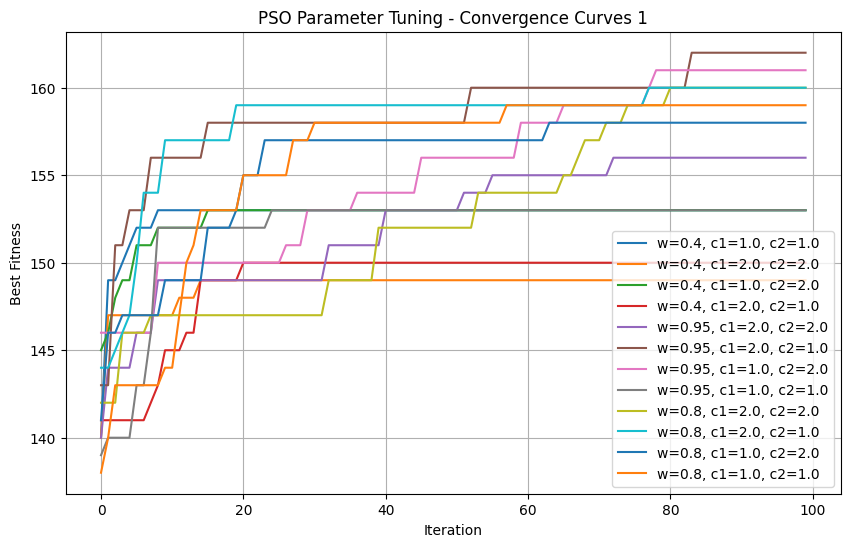

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 50 subsets


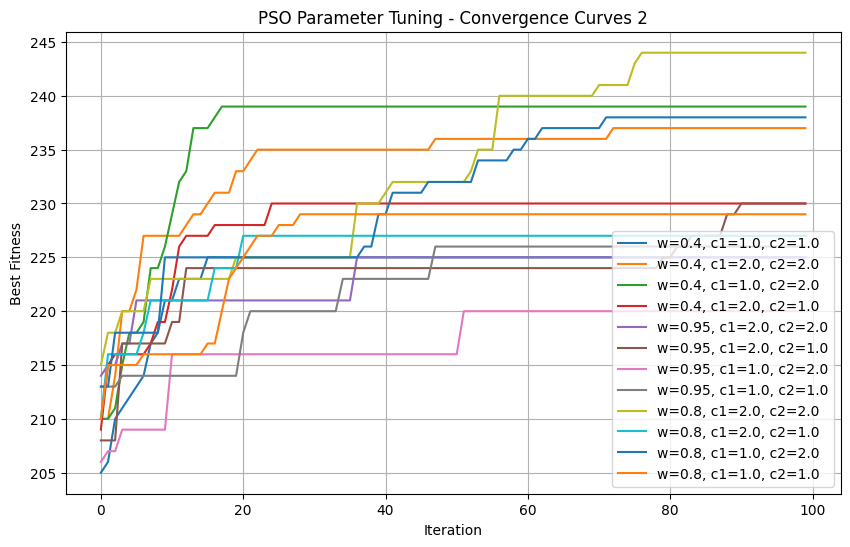

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 18 subsets


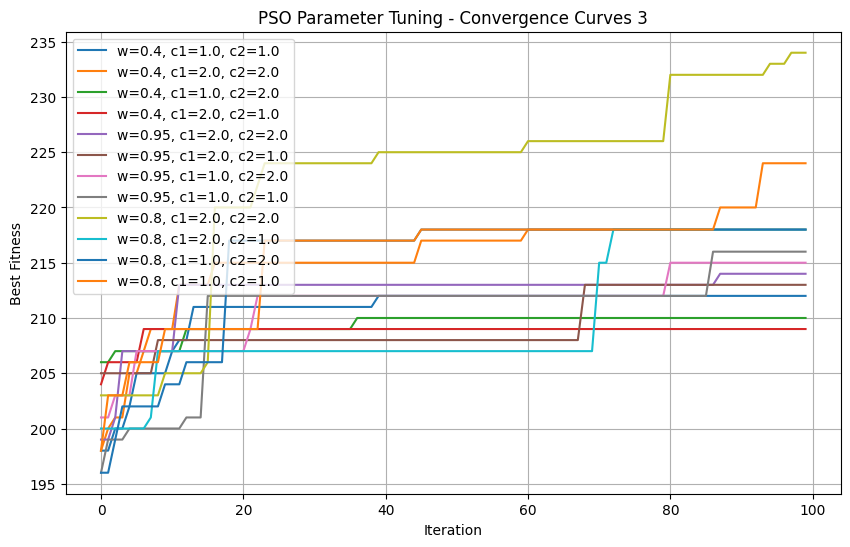

Problem instance loaded: 400 elements, 4000 subsets
Selecting k = 44 subsets


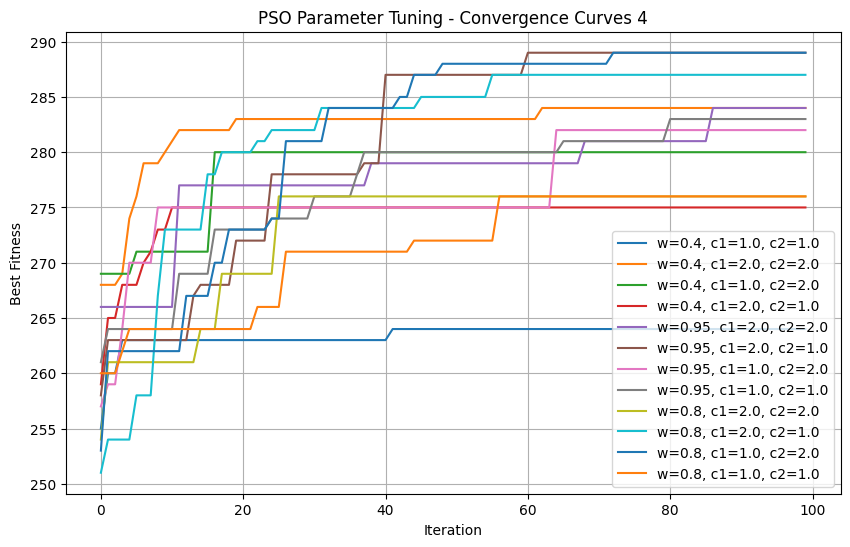

In [ ]:
parameter_tuning_experiment(universe41,subsets41 , "1",len(subsets41)//20) 
parameter_tuning_experiment(universea1,subsetsa1 , "2",len(subsetsa1)//60) 
parameter_tuning_experiment(universeb2,subsetsb2 , "3",len(subsetsb2)//160) 
parameter_tuning_experiment(universec3,subsetsc3 , "4",len(subsetsc3)//90) 

def print_results(sol1 ,sol2, sol3, sol4, u1, u2, u3, u4 ):
    """Helper function to print all results"""
    print("\n=== Final Results ===")
    print(f"1. Covered {sol1['fitness']}/{len(u1)} elements")
    print(f"1. Covered {sol2['fitness']}/{len(u2)} elements")
    print(f"2. Covered {sol3['fitness']}/{len(u3)} elements")
    print(f"3. Covered {sol4['fitness']}/{len(u4)} elements")
   

In [12]:
def test(universe, subsets,filename, k, w, c1, c2,swarm_size,max_iter):
    
    diversity=[]
    # Problem setup
    problem = MaximumCoveringProblem(universe, subsets, k)
    print(f"\nAnalyzing {filename}:")
    print(f"Problem loaded: {len(universe)} elements, {len(subsets)} subsets, selecting k={k} subsets")
    
    # Run PSO optimization
    pso = DiscretePSO(problem, num_particles=swarm_size, max_iter=max_iter, w=w, c1=c1, c2=c2)
    best_solution, convergence,diversity = pso.optimize()
    
    # Print results
    print(f"Best solution for {filename}: {best_solution['fitness']} elements covered "
          f"({best_solution['fitness']/len(universe)*100:.2f}% coverage)")
    
    # Plot convergence
    plt.subplot(2, 2, 1)
    plt.plot(convergence)
    plt.title(f"Coverage Convergence - {filename}")
    plt.xlabel("Iteration")
    plt.ylabel("Elements Covered")
    plt.grid(True)
    
    # Add additional visualizations if needed
    # plt.subplot(2, 2, 2) ... etc
    
    plt.tight_layout()
    plt.show()
    
    return best_solution, convergence,diversity
    


    

In [74]:
best_solution,convergence,div=test(universe41, subsets41, "scp41.txt", len(subsets41)//20, w=0.9, c1=2.05, c2=1.5,swarm_size=1000,max_iter=150)
print(best_solution)
print(convergence)


Analyzing scp41.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets


KeyboardInterrupt: 


Analyzing scp41.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets
Best solution for scp41.txt: 164 elements covered (82.00% coverage)


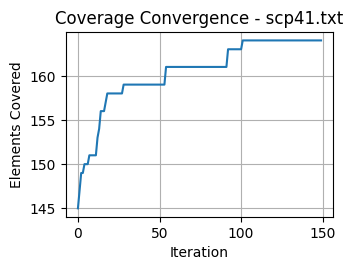

{'position': array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 6.81095337e-02, 1.00000000e+00,
       1.00000000e+00, 4.58447694e-01, 2.90366864e-02, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.99978224e-01, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 6.55519752e-01, 1.50427863e-01, 9.54152817e-01,
       1.00000000e+00, 1.25913643e-02, 0.00000000e+00, 1.00000000e+00,
       8.38017555e-01, 3.76841169e-01, 0.00000000e+00, 9.99747892e-01,
       0.00000000e+00, 7.90660057e-04, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.04952182e-01, 0.00000000e+00,
       1.33425396e-01, 3.92318509e-01, 0.00000000e+00, 3.63882365e-02,
       0.00000000e+00, 2.92217457e-01, 1.00000000e+00, 1.00000000e+00,
       4.26731476e-01, 0.00000000e+00, 0.00000000e+00, 3.61272071e-04,
       0.00000000e+00, 5.57650898e-01, 0.00000000e+00, 0.0000000

In [75]:
best_solution,convergence,div=test(universe41, subsets41, "scp41.txt", len(subsets41)//20, w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
print(best_solution)
print(convergence)

In [44]:
convergences4=[]
problem_set_4_div=[]

-----TEST 4-----

Analyzing scp41.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets
Best solution for scp41.txt: 167 elements covered (83.50% coverage)


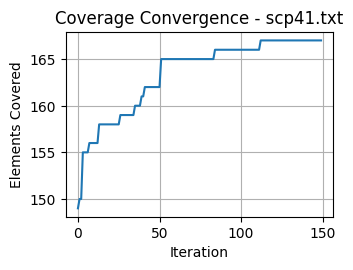


Analyzing scp42.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp42.txt: 163 elements covered (81.50% coverage)


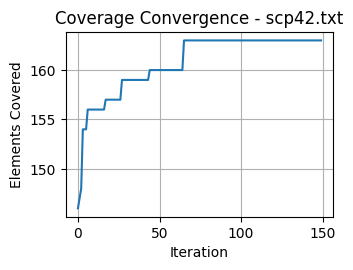


Analyzing scp43.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp43.txt: 166 elements covered (83.00% coverage)


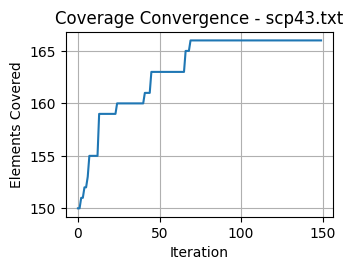


Analyzing scp44.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets
Best solution for scp44.txt: 162 elements covered (81.00% coverage)


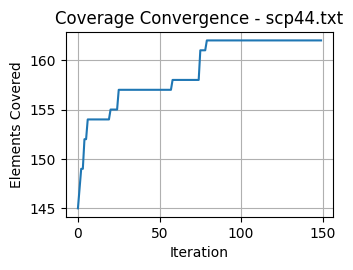


Analyzing scp45.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp45.txt: 174 elements covered (87.00% coverage)


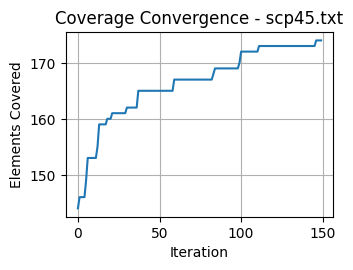


Analyzing scp46.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets
Best solution for scp46.txt: 168 elements covered (84.00% coverage)


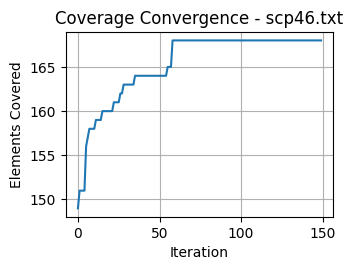


Analyzing scp47.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp47.txt: 157 elements covered (78.50% coverage)


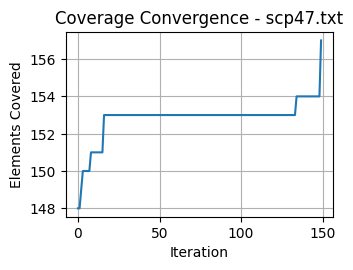


Analyzing scp48.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=50 subsets
Best solution for scp48.txt: 163 elements covered (81.50% coverage)


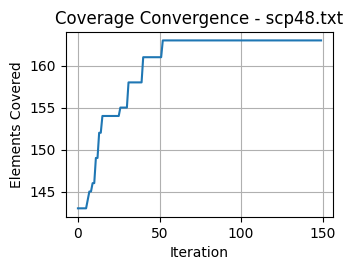


Analyzing scp49.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp49.txt: 165 elements covered (82.50% coverage)


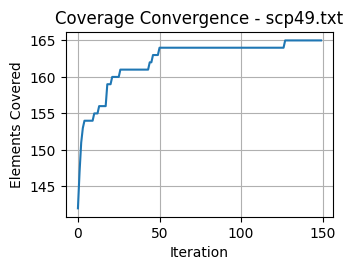


Analyzing scp410.txt:
Problem loaded: 200 elements, 1000 subsets, selecting k=52 subsets
Best solution for scp410.txt: 169 elements covered (84.50% coverage)


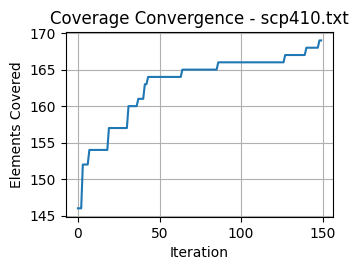

In [45]:
print("-----TEST 4-----")
bs41,cng41,div41=test(universe41, subsets41, "scp41.txt", len(subsets41)//int(k41), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng41)
problem_set_4_div.append(div41)
bs42,cng42,div42=test(universe42, subsets42, "scp42.txt", len(subsets41)//int(k42), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng42)
problem_set_4_div.append(div42)
bs43,cng43,div43=test(universe43, subsets43, "scp43.txt", len(subsets41)//int(k43), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng43)
problem_set_4_div.append(div43)
bs44,cng44,div44=test(universe44, subsets44, "scp44.txt", len(subsets41)//int(k44), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng44)
problem_set_4_div.append(div44)
bs45,cng45,div45=test(universe45, subsets45, "scp45.txt", len(subsets41)//int(k45), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng45)
problem_set_4_div.append(div45)
bs46,cng46,div46=test(universe46, subsets46, "scp46.txt", len(subsets41)//int(k46), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng46)
problem_set_4_div.append(div46)
bs47,cng47,div47=test(universe47, subsets47, "scp47.txt", len(subsets41)//int(k47), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng47)
problem_set_4_div.append(div47)
bs48,cng48,div48=test(universe48, subsets48, "scp48.txt", len(subsets41)//int(k48), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng48)
problem_set_4_div.append(div48)
bs49,cng49,div49=test(universe49, subsets49, "scp49.txt", len(subsets41)//int(k49), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng49)
problem_set_4_div.append(div49)
bs410,cng410,div410=test(universe410, subsets410,"scp410.txt", len(subsets41)//int(k410), w=0.9, c1=2.05, c2=1.5,swarm_size=80,max_iter=150)
convergences4.append(cng410)
problem_set_4_div.append(div410)

In [46]:
convergencesa=[]
problem_set_a_div=[]

In [ ]:
bsa1,cvga1,diva1=test(universea1, subsetsa1, "scpa1.txt", len(subsetsa1)//int(ka1), w=0.8, c1=1.5, c2=1.5, swarm_size=1000, max_iter=100)

-----TEST A-----

Analyzing scpa1.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for scpa1.txt: 222 elements covered (74.00% coverage)


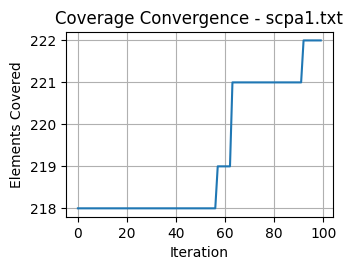


Analyzing scpa2.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for scpa2.txt: 229 elements covered (76.33% coverage)


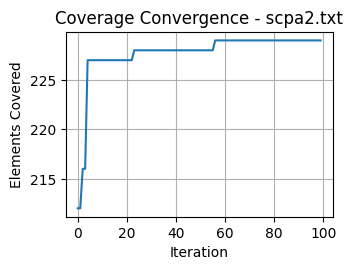


Analyzing scpa3.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for scpa3.txt: 226 elements covered (75.33% coverage)


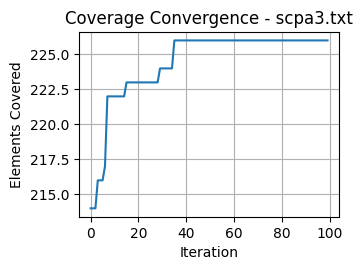


Analyzing scpa4.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for scpa4.txt: 227 elements covered (75.67% coverage)


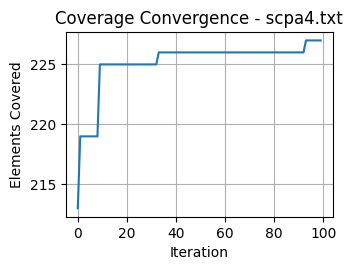


Analyzing scpa5.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for scpa5.txt: 234 elements covered (78.00% coverage)


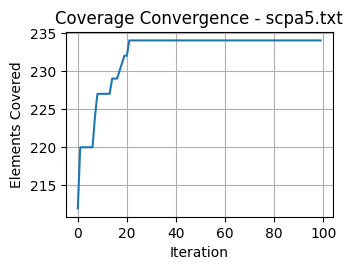

In [47]:
print("-----TEST A-----")
bsa1,cvga1,diva1=test(universea1, subsetsa1, "scpa1.txt", len(subsetsa1)//int(ka1), w=0.8, c1=1.5, c2=1.5, swarm_size=100, max_iter=100)
convergencesa.append(cvga1)
problem_set_a_div.append(diva1)
bsa2,cvga2,diva2=test(universea2, subsetsa2, "scpa2.txt", len(subsetsa1)//int(ka2), w=0.8, c1=1.5, c2=1.5, swarm_size=100, max_iter=100)
convergencesa.append(cvga2)
problem_set_a_div.append(diva2)
bsa3,cvga3,diva3=test(universea3, subsetsa3, "scpa3.txt", len(subsetsa1)//int(ka3), w=0.8, c1=1.5, c2=1.5, swarm_size=100, max_iter=100)
convergencesa.append(cvga3)
problem_set_a_div.append(diva3)
bsa4,cvga4,diva4=test(universea4, subsetsa4, "scpa4.txt", len(subsetsa1)//int(ka4), w=0.8, c1=1.5, c2=1.5, swarm_size=100, max_iter=100)
convergencesa.append(cvga4)
problem_set_a_div.append(diva4)
bsa5,cvga5,diva5=test(universea5, subsetsa5, "scpa5.txt", len(subsetsa1)//int(ka5), w=0.8, c1=1.5, c2=1.5, swarm_size=100, max_iter=100)
convergencesa.append(cvga5)
problem_set_a_div.append(diva5)

In [49]:
convergencesb=[]
problem_set_b_div=[]

-----TEST B-----

Analyzing Problem_set_b/scpb1.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=20 subsets
Best solution for Problem_set_b/scpb1.txt: 227 elements covered (75.67% coverage)


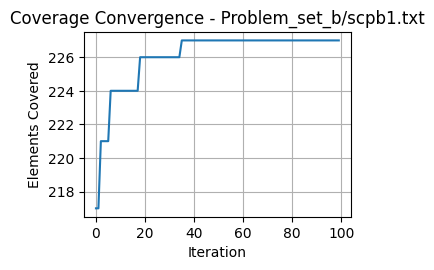


Analyzing Problem_set_b/scpb2.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=20 subsets
Best solution for Problem_set_b/scpb2.txt: 219 elements covered (73.00% coverage)


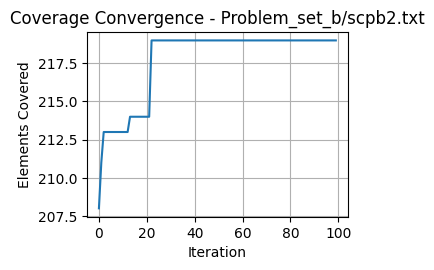


Analyzing Problem_set_b/scpb3.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=20 subsets
Best solution for Problem_set_b/scpb3.txt: 230 elements covered (76.67% coverage)


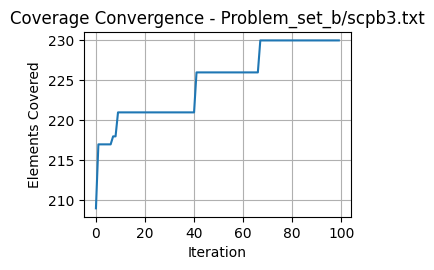


Analyzing Problem_set_b/scpb4.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=20 subsets
Best solution for Problem_set_b/scpb4.txt: 238 elements covered (79.33% coverage)


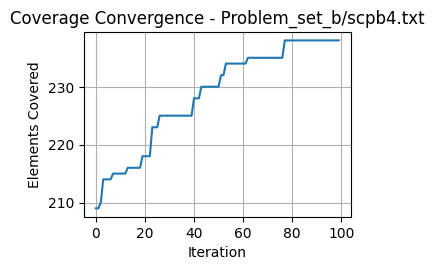


Analyzing Problem_set_b/scpb5.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=20 subsets
Best solution for Problem_set_b/scpb5.txt: 232 elements covered (77.33% coverage)


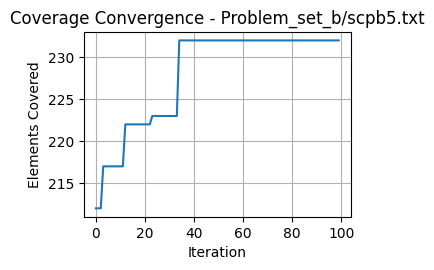

In [50]:
print("-----TEST B-----")
# test B
bsb1,cvgb1,divb1=test(universeb1, subsetsb1, "Problem_set_b/scpb1.txt", len(subsetsb1)//int(kb1), w=0.9, c1=2.05, c2=2.05, swarm_size=50, max_iter=100)
convergencesb.append(cvgb1)
problem_set_b_div.append(divb1)
bsb2,cvgb2,divb2=test(universeb2, subsetsb2, "Problem_set_b/scpb2.txt", len(subsetsb1)//int(kb2), w=0.9, c1=2.05, c2=2.05, swarm_size=50, max_iter=100)
convergencesb.append(cvgb2)
problem_set_b_div.append(divb2)
bsb3,cvgb3,divb3=test(universeb3, subsetsb3, "Problem_set_b/scpb3.txt", len(subsetsb1)//int(kb3), w=0.8, c1=2.05, c2=2.05, swarm_size=50, max_iter=100)
convergencesb.append(cvgb3)
problem_set_b_div.append(divb3)
bsb4,cvgb4,divb4=test(universeb4, subsetsb4, "Problem_set_b/scpb4.txt", len(subsetsb1)//int(kb4),w=0.8, c1=2.05, c2=2.05, swarm_size=50, max_iter=100)
convergencesb.append(cvgb4)
problem_set_b_div.append(divb4)
bsb5,cvgb5,divb5=test(universeb5, subsetsb5, "Problem_set_b/scpb5.txt", len(subsetsb1)//int(kb5), w=0.8, c1=2.05, c2=2.05, swarm_size=50, max_iter=100)
convergencesb.append(cvgb5)
problem_set_b_div.append(divb5)

In [36]:
print(convergencesb)

[[203, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215], [201, 205, 205, 205, 205, 205, 205, 206, 206, 208, 208, 208, 209, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 222, 222, 224, 224, 224, 224, 224, 224, 224, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 2

In [54]:
convergencesc=[]
problem_set_c_div=[]

-----TEST C-----

Analyzing Problem_set_c/scpc1.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=60 subsets
Best solution for Problem_set_c/scpc1.txt: 327 elements covered (81.75% coverage)


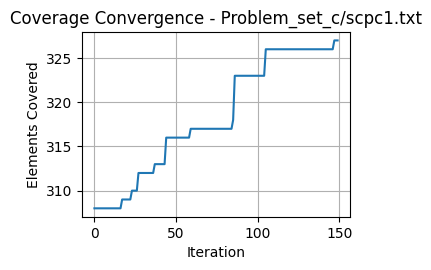


Analyzing Problem_set_c/scpc2.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=60 subsets
Best solution for Problem_set_c/scpc2.txt: 325 elements covered (81.25% coverage)


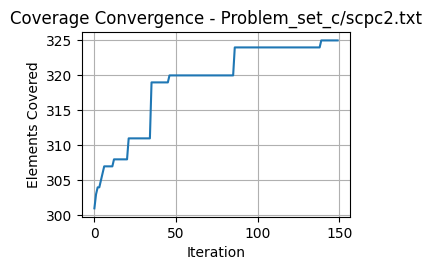


Analyzing Problem_set_c/scpc3.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=60 subsets
Best solution for Problem_set_c/scpc3.txt: 317 elements covered (79.25% coverage)


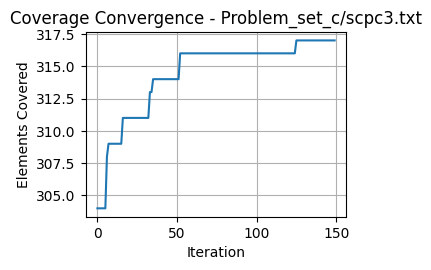


Analyzing Problem_set_c/scpc4.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=60 subsets
Best solution for Problem_set_c/scpc4.txt: 317 elements covered (79.25% coverage)


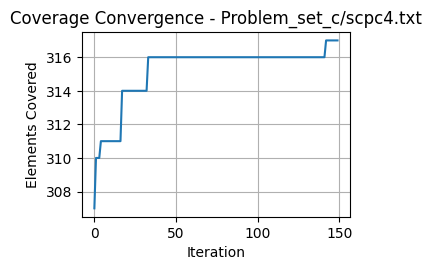


Analyzing Problem_set_c/scpc5.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=60 subsets
Best solution for Problem_set_c/scpc5.txt: 326 elements covered (81.50% coverage)


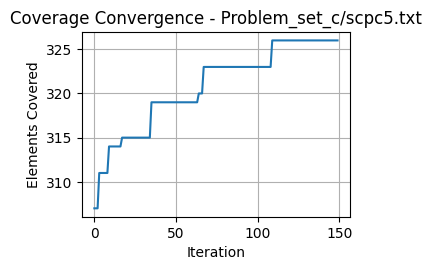

In [58]:
print("-----TEST C-----")
# test c
bsc1,cvgc1,divc1=test(universec1, subsetsc1, "Problem_set_c/scpc1.txt", 60, w=0.9, c1=1.5, c2=1.5, swarm_size=80, max_iter=150)
convergencesc.append(cvgc1)
problem_set_c_div.append(divc1)
bsc2,cvgc2,divc2=test(universec2, subsetsc2, "Problem_set_c/scpc2.txt", 60, w=0.9, c1=1.5, c2=1.5, swarm_size=80, max_iter=150)
convergencesc.append(cvgc2)
problem_set_c_div.append(divc2)
bsc3,cvgc3,divc3=test(universec3, subsetsc3, "Problem_set_c/scpc3.txt", 60, w=0.9, c1=1.5, c2=1.5, swarm_size=80, max_iter=150)
convergencesc.append(cvgc3)
problem_set_c_div.append(divc3)
bsc4,cvgc4,divc4=test(universec4, subsetsc4, "Problem_set_c/scpc4.txt",60, w=0.9, c1=1.5, c2=1.5, swarm_size=80, max_iter=150)
convergencesc.append(cvgc4)
problem_set_c_div.append(divc4)
bsc5,cvgc5,divc5=test(universec5, subsetsc5, "Problem_set_c/scpc5.txt", 60,w=0.9, c1=1.5, c2=1.5, swarm_size=80, max_iter=150)
problem_set_c_div.append(divc5)

In [52]:
def compute_mean_curve(convergence_list):
    # Trouver la longueur maximale parmi toutes les courbes
    max_length = max(len(conv) for conv in convergence_list)
    
    # Normaliser toutes les courbes à la même longueur
    normalized = []
    for conv in convergence_list:
        if len(conv) < max_length:
            # Compléter avec la dernière valeur
            normalized.append(conv + [conv[-1]] * (max_length - len(conv)))
        else:
            normalized.append(conv[:max_length])
    
    # Calculer la moyenne et l'écart-type
    mean_curve = np.mean(normalized, axis=0)
    std_curve = np.std(normalized, axis=0)
    
    return mean_curve, std_curve, max_length


In [59]:
# Calcul des courbes moyennes pour chaque Problem Set
meanA, stdA, lenA = compute_mean_curve(convergencesa)  # scpa1-scpa5
meanB, stdB, lenB = compute_mean_curve(convergencesb)  # scpb1-scpb5
meanC, stdC, lenC = compute_mean_curve(convergencesc)  # scpc1-scpc5
mean4, std4, len4 = compute_mean_curve(convergences4)  # scp41-scp410


In [60]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


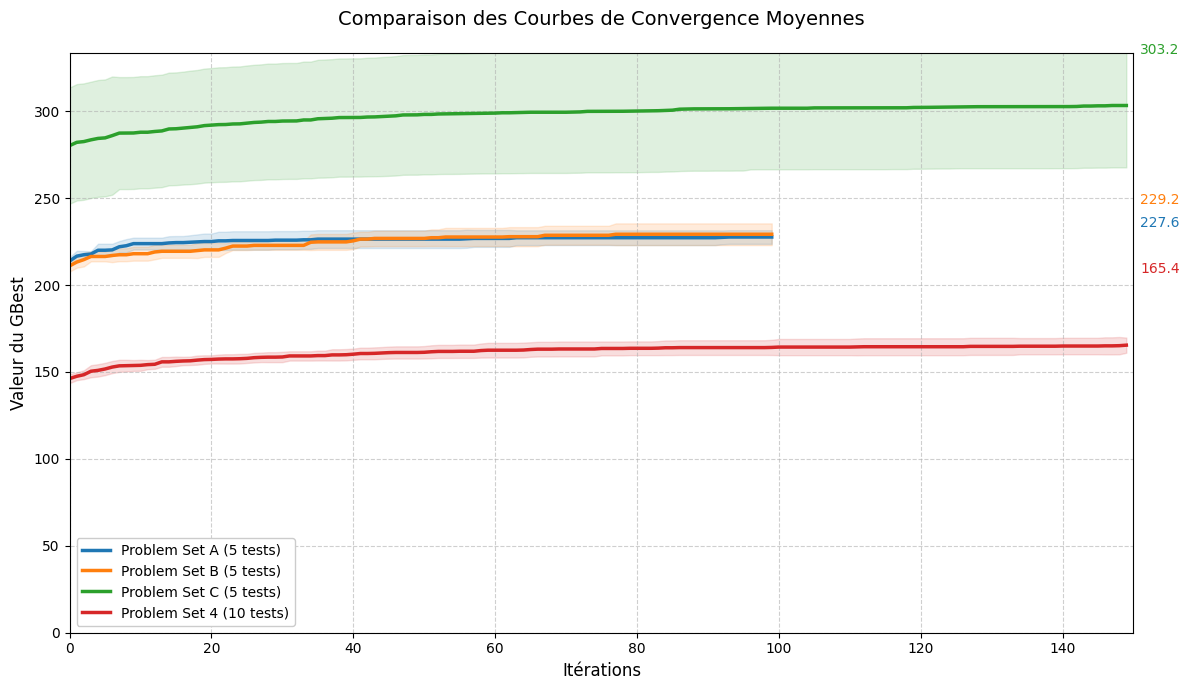

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
# Configuration du graphique
plt.figure(figsize=(12, 7))



# Couleurs personnalisées
colors = {
    'A': '#1f77b4',  # Bleu
    'B': '#ff7f0e',  # Orange
    'C': '#2ca02c',  # Vert
    '4': '#d62728'   # Rouge
}

# Tracé des courbes moyennes avec zones d'incertitude
def plot_with_band(x, mean, std, label, color):
    plt.plot(x, mean, label=label, color=color, linewidth=2.5)
    plt.fill_between(x, mean-std, mean+std, color=color, alpha=0.15)

max_iter = max(lenA, lenB, lenC, len4)
x_vals = np.arange(max_iter)

plot_with_band(x_vals[:lenA], meanA, stdA, 'Problem Set A (5 tests)', colors['A'])
plot_with_band(x_vals[:lenB], meanB, stdB, 'Problem Set B (5 tests)', colors['B'])
plot_with_band(x_vals[:lenC], meanC, stdC, 'Problem Set C (5 tests)', colors['C'])
plot_with_band(x_vals[:len4], mean4, std4, 'Problem Set 4 (10 tests)', colors['4'])

# Personnalisation avancée
plt.title('Comparaison des Courbes de Convergence Moyennes', fontsize=14, pad=20)
plt.xlabel('Itérations', fontsize=12)
plt.ylabel('Valeur du GBest', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, framealpha=1)

# Ajustements des axes
plt.xlim(0, max_iter)
plt.ylim(0, max(max(meanA), max(meanB), max(meanC), max(mean4)) * 1.1)

# Ajout d'annotations pour les valeurs finales
def add_final_value(mean, color, y_offset=0):
    final_val = mean[-1]
    plt.annotate(f'{final_val:.1f}', 
                xy=(max_iter, final_val),
                xytext=(5, y_offset), 
                textcoords='offset points',
                color=color,
                fontsize=10,
                va='center')

add_final_value(meanA, colors['A'], 10)
add_final_value(meanB, colors['B'], 25)
add_final_value(meanC, colors['C'], 40)
add_final_value(mean4, colors['4'], 55)

plt.tight_layout()
plt.savefig('comparison_mean_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
def standardize_diversity(diversity_history, max_iter=100):
    if len(diversity_history) < max_iter:
        # Pad with last value if shorter
        last_value = diversity_history[-1]
        padded = diversity_history + [last_value] * (max_iter - len(diversity_history))
        return padded
    else:
        # Truncate if longer
        return diversity_history[:max_iter]

# Apply to all files
standardized_data = {
    "Problem_Set_1": [standardize_diversity(d) for d in problem_set_4_div],
    "Problem_Set_2": [standardize_diversity(d) for d in problem_set_a_div],
    "Problem_Set_3": [standardize_diversity(d) for d in problem_set_b_div],
    "Problem_Set_4": [standardize_diversity(d) for d in problem_set_c_div],

}

In [63]:
avg_diversity = {}
std_diversity = {}

for set_name, files in standardized_data.items():
    stacked = np.array(files)  # Shape: (5 files × 100 iterations)
    avg_diversity[set_name] = np.mean(stacked, axis=0)
    std_diversity[set_name] = np.std(stacked, axis=0)

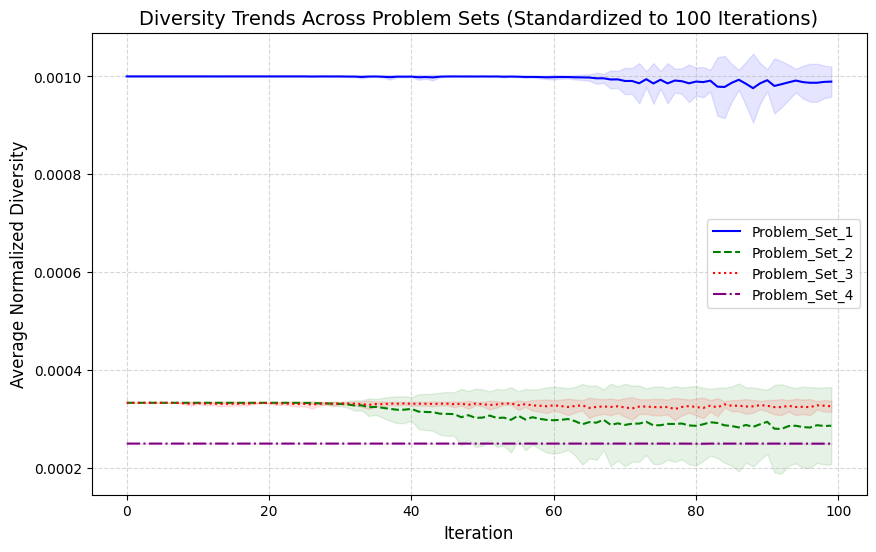

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']
linestyles = ['-', '--', ':', '-.']

for idx, (set_name, color, ls) in enumerate(zip(avg_diversity.keys(), colors, linestyles)):
    mean = avg_diversity[set_name]
    std = std_diversity[set_name]
    iterations = range(100)
    
    plt.plot(iterations, mean, label=set_name, color=color, linestyle=ls)
    plt.fill_between(iterations, mean - std, mean + std, alpha=0.1, color=color)

plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Average Normalized Diversity", fontsize=12)
plt.title("Diversity Trends Across Problem Sets (Standardized to 100 Iterations)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [70]:
problem = MaximumCoveringProblem(universe41, subsets41, 40)

# 2. Run DFS with timeout
solution, coverage = problem.solve_with_DFS(max_time=1800)  # 30 second timeout

# 3. Interpret results
if solution:
    print(f"Optimal coverage: {coverage}/{len(universe41)} elements")
    selected = [i for i, val in enumerate(solution) if val == 1]
    print(f"Selected subsets: {selected}")
    print(f"Covered elements: {set().union(*[subsets[i] for i in selected])}")
else:
    print("DFS timed out before finding solution")

New best DFS solution found with coverage: 106
New best DFS solution found with coverage: 107
New best DFS solution found with coverage: 109
New best DFS solution found with coverage: 110
New best DFS solution found with coverage: 112
New best DFS solution found with coverage: 113
New best DFS solution found with coverage: 114
New best DFS solution found with coverage: 115
New best DFS solution found with coverage: 116
New best DFS solution found with coverage: 118
New best DFS solution found with coverage: 119
New best DFS solution found with coverage: 120
New best DFS solution found with coverage: 121
New best DFS solution found with coverage: 122
New best DFS solution found with coverage: 123
New best DFS solution found with coverage: 124
Number of DFS solutions evaluated: 16
Optimal coverage: 124/200 elements
Selected subsets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 575, 583, 767]
Cov

In [71]:
problem = MaximumCoveringProblem(universeb1, subsetsb1, 40)

# 2. Run DFS with timeout
solution, coverage = problem.solve_with_DFS(max_time=1800)  # 30 second timeout

# 3. Interpret results
if solution:
    print(f"Optimal coverage: {coverage}/{len(universe41)} elements")
    selected = [i for i, val in enumerate(solution) if val == 1]
    print(f"Selected subsets: {selected}")
    print(f"Covered elements: {set().union(*[subsets[i] for i in selected])}")
else:
    print("DFS timed out before finding solution")

New best DFS solution found with coverage: 278
New best DFS solution found with coverage: 280
New best DFS solution found with coverage: 281
New best DFS solution found with coverage: 282
New best DFS solution found with coverage: 283
New best DFS solution found with coverage: 284
Number of DFS solutions evaluated: 6
Optimal coverage: 284/200 elements
Selected subsets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 1538, 2520]


IndexError: list index out of range

In [72]:
problem = MaximumCoveringProblem(universec1, subsetsc1, 40)

# 2. Run DFS with timeout
solution, coverage = problem.solve_with_DFS(max_time=1800)  # 30 second timeout

# 3. Interpret results
if solution:
    print(f"Optimal coverage: {coverage}/{len(universe41)} elements")
    selected = [i for i, val in enumerate(solution) if val == 1]
    print(f"Selected subsets: {selected}")
    print(f"Covered elements: {set().union(*[subsets[i] for i in selected])}")
else:
    print("DFS timed out before finding solution")

New best DFS solution found with coverage: 221
New best DFS solution found with coverage: 222
New best DFS solution found with coverage: 223
New best DFS solution found with coverage: 225
New best DFS solution found with coverage: 227
New best DFS solution found with coverage: 228
New best DFS solution found with coverage: 229
New best DFS solution found with coverage: 230
New best DFS solution found with coverage: 233
New best DFS solution found with coverage: 234
New best DFS solution found with coverage: 235
New best DFS solution found with coverage: 237
New best DFS solution found with coverage: 238
New best DFS solution found with coverage: 239
New best DFS solution found with coverage: 240
New best DFS solution found with coverage: 241
New best DFS solution found with coverage: 242
New best DFS solution found with coverage: 243
Number of DFS solutions evaluated: 18
Optimal coverage: 243/200 elements
Selected subsets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

IndexError: list index out of range

In [ ]:
import numpy as np
from multiprocessing import Pool
import time

# Paramètres de l'algorithme
NUM_PARTICLES = 50   # Taille de l'essaim
MAX_ITER = 100       # Nombre d'itérations
C1 = 1.5             # Coefficient cognitif
C2 = 2.0             # Coefficient social
W = 0.9             # Poids d'inertie
K = 44               # Nombre fixe de sous-ensembles à sélectionner (ex: 44)

# Exemple de problème Set Cover (à adapter avec vos données)
UNIVERSE_SIZE = len(universe41)  # Nombre d'éléments à couvrir
SUBSETS = [...]      # Liste de sous-ensembles (ex: [[1,2], [3,4], ...])

class Particle:
    def __init__(self, subsets):
        # Initialisation aléatoire avec exactement K sous-ensembles sélectionnés
        self.position = np.zeros(len(subsets), dtype=int)
        selected = np.random.choice(len(subsets), K, replace=False)
        self.position[selected] = 1
        self.velocity = np.random.rand(len(subsets))  # Vitesse initiale aléatoire
        self.best_position = np.copy(self.position)
        self.best_score = -np.inf

    def update_velocity(self, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive = C1 * r1 * (self.best_position - self.position)
        social = C2 * r2 * (global_best_position - self.position)
        self.velocity = W * self.velocity + cognitive + social

    def update_position(self):
        # Appliquer la contrainte : sélectionner exactement K sous-ensembles
        probas = 1 / (1 + np.exp(-self.velocity))  # Sigmoïde pour convertir en probabilités
        # Choix des K meilleurs sous-ensembles basés sur les probabilités
        selected = np.argpartition(probas, -K)[-K:]
        self.position = np.zeros_like(self.position)
        self.position[selected] = 1

def evaluate(particle):
    """Calcule le fitness (taux de couverture)."""
    selected_subsets = [SUBSETS[i] for i, bit in enumerate(particle.position) if bit == 1]
    covered = set().union(*selected_subsets)
    return len(covered) / UNIVERSE_SIZE  # Taux de couverture (ex: 0.73 pour 73%)

def parallel_pso(subsets, num_processes=4):
    particles = [Particle(subsets) for _ in range(NUM_PARTICLES)]
    global_best_position = np.zeros(len(subsets), dtype=int)
    global_best_score = -np.inf

    with Pool(num_processes) as pool:
        for _ in range(MAX_ITER):
            # Évaluation en parallèle
            scores = pool.map(evaluate, particles)
            
            # Mise à jour des meilleures solutions
            for i, score in enumerate(scores):
                if score > particles[i].best_score:
                    particles[i].best_score = score
                    particles[i].best_position = particles[i].position.copy()
                if score > global_best_score:
                    global_best_score = score
                    global_best_position = particles[i].position.copy()

            # Mise à jour des vitesses/positions
            for p in particles:
                p.update_velocity(global_best_position)
                p.update_position()

    return global_best_position, global_best_score

In [ ]:
best_solution, best_score = parallel_pso(subsets41)
print(f"Couverture: {best_score * 100:.1f}%")

Parallel pso


In [15]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeable
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from concurrent.futures import ThreadPoolExecutor  # ou ProcessPoolExecutor
import numpy as np
class ParallelDiscretePSO:
    def __init__(self, problem, num_particles=100, max_iter=100, w=0.8, c1=2.05, c2=2.05):
        self.problem = problem
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.particles = []
        for _ in range(num_particles):
            position = np.random.rand(problem.m)
            binary_solution = self._discretize(position)
            velocity = np.random.randn(problem.m) * 0.1
            fitness = problem.evaluate(binary_solution)

            pbest = {
                'position': position.copy(),
                'binary_solution': binary_solution.copy(),
                'fitness': fitness
            }

            self.particles.append({
                'position': position,
                'velocity': velocity,
                'binary_solution': binary_solution,
                'fitness': fitness,
                'pbest': pbest
            })

        self.gbest = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest'].copy()

    def _discretize(self, position):
        """Convert a continuous position to a binary solution with exactly k 1's"""
        top_k_indices = np.argpartition(position, -self.problem.k)[-self.problem.k:]
        binary_solution = [0] * self.problem.m
        for idx in top_k_indices:
            binary_solution[idx] = 1
        return binary_solution

    def optimize(self):
        convergence_curve = []
        best_fitness_history = []
        diversity_history = []

        for iteration in range(self.max_iter):
            current_binary_solutions = []

            # ⏱️ PARALLÉLISME ICI
            def update_particle(particle):
                r1, r2 = np.random.rand(2)
                cognitive = self.c1 * r1 * (particle['pbest']['position'] - particle['position'])
                social = self.c2 * r2 * (self.gbest['position'] - particle['position'])
                particle['velocity'] = self.w * particle['velocity'] + cognitive + social
                particle['position'] = np.clip(particle['position'] + particle['velocity'], 0, 1)
                particle['binary_solution'] = self._discretize(particle['position'])
                particle['fitness'] = self.problem.evaluate(particle['binary_solution'])

                # Met à jour le pbest
                if particle['fitness'] > particle['pbest']['fitness']:
                    particle['pbest'] = {
                        'position': particle['position'].copy(),
                        'binary_solution': particle['binary_solution'].copy(),
                        'fitness': particle['fitness']
                    }
                return particle

            with ThreadPoolExecutor() as executor:
                self.particles = list(executor.map(update_particle, self.particles))

            current_binary_solutions = [p['binary_solution'] for p in self.particles]
            diversity = calculate_diversity(current_binary_solutions)
            diversity_history.append(diversity)

            # Mise à jour du gbest
            current_best = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest']
            if current_best['fitness'] > self.gbest['fitness']:
                self.gbest = current_best.copy()

            convergence_curve.append(self.gbest['fitness'])
            best_fitness_history.append(self.gbest['fitness'])

            if self.gbest['fitness'] == self.problem.n:
                break

        return self.gbest, convergence_curve, diversity_history


pso parallel (multi-processeur)

In [66]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# Fonction de mise à jour des particules
def update_particle_process(particle, gbest_position, c1, c2, w, problem_k, problem_m, problem_S):
    # Logique pour la mise à jour des particules
    # Exemple de mise à jour basique pour illustration
    new_velocity = w * np.array(particle['velocity']) + c1 * np.random.rand() * (np.array(particle['pbest']['position']) - np.array(particle['position'])) + c2 * np.random.rand() * (np.array(gbest_position) - np.array(particle['position']))
    new_position = (np.random.rand(problem_m) < 1 / (1 + np.exp(-new_velocity))).astype(int)
    
    # Calcul du fitness
    fitness = evaluate_fitness(new_position, problem_S)
    
    # Retourne la particule mise à jour
    return {'position': new_position, 'velocity': new_velocity, 'pbest': {'position': new_position, 'fitness': fitness}, 'fitness': fitness}

# Fonction d'évaluation de la fitness (en fonction des sous-ensembles sélectionnés)
def evaluate_fitness(position, problem_S):
    selected_subsets = [problem_S[i] for i in range(len(position)) if position[i] == 1]
    covered = set()
    for subset in selected_subsets:
        covered.update(subset)
    return len(covered)

class ParallelDiscretePSOP:
    def __init__(self, problem, num_particles=100, max_iter=100):
        self.problem = problem
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.particles = self.initialize_particles()
        self.gbest = {'position': [], 'fitness': -1}
        self.c1 = 2.05
        self.c2 = 2.05
        self.w = 0.9
    
    def initialize_particles(self):
        particles = []
        for _ in range(self.num_particles):
            position = np.random.rand(self.problem.m) < 0.5
            velocity = np.random.randn(self.problem.m) * 0.1
            fitness = evaluate_fitness(position, self.problem.S)
            particles.append({'position': position, 'velocity': velocity, 'pbest': {'position': position, 'fitness': fitness}, 'fitness': fitness})
        return particles
    
    def optimize(self):
        """Exécute l'optimisation PSO avec parallélisation"""
        convergence_curve = []
        diversity_history = []

        for iteration in range(self.max_iter):
            # Convertir les particules en un format simple (listes, dictionnaires)
            particles_to_map = [{
                'position': p['position'],
                'pbest': p['pbest'],
                'velocity': p['velocity'],
                'fitness': p['fitness'],
            } for p in self.particles]

            # Parallélisation avec ProcessPoolExecutor
            with ProcessPoolExecutor() as executor:
                func = partial(
                    update_particle_process,
                    gbest_position=self.gbest['position'],
                    c1=self.c1,
                    c2=self.c2,
                    w=self.w,
                    problem_k=self.problem.k,
                    problem_m=self.problem.m,
                    problem_S=self.problem.S
                )
                # Appliquer la fonction de mise à jour en parallèle
                updated_particles = list(executor.map(func, particles_to_map))

            # Mise à jour des particules avec les résultats du parallèle
            for i, updated_particle in enumerate(updated_particles):
                self.particles[i] = updated_particle

            # Calcul de la diversité et mise à jour du meilleur global (gbest)
            diversity = self.calculate_diversity(self.particles)
            diversity_history.append(diversity)

            current_best = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest']
            if current_best['fitness'] > self.gbest['fitness']:
                self.gbest = current_best.copy()

            convergence_curve.append(self.gbest['fitness'])

            if self.gbest['fitness'] == self.problem.n:
                break

        return self.gbest, convergence_curve, diversity_history

    def calculate_diversity(self, particles):
        """Calcul de la diversité des solutions"""
        return np.std([particle['fitness'] for particle in particles])  # Exemple simple de calcul de diversité

# Exemple d'utilisation
problem = MaximumCoveringProblem(universe41, subsets41, len(subsets41)//int(k41))
pso = ParallelDiscretePSO(problem, num_particles=900,max_iter=100, w=0.9, c1=2.05, c2=1.0)
gbest, convergence, diversity = pso.optimize()

print(f"Best fitness: {gbest['fitness']}/{problem.n} elements covered")


Best fitness: 178/200 elements covered


In [40]:
problem = MaximumCoveringProblem(universe41, subsets41, int(k41))
pso = ParallelDiscretePSO(problem, num_particles=1000)
gbest, convergence, diversity = pso.optimize()
print(f"Best fitness: {gbest['fitness']}/{problem.n} elements covered")

KeyboardInterrupt: 